<a href="https://colab.research.google.com/github/JinyangWang27/singleChannel2DV/blob/main/singleChannel2DV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A single channel 2DV model (Ianniello, 1977)

In [37]:
#@title ### Install, import dependencies 
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy import integrate

# fsize=20
# plt.rc('lines', linewidth=2)
# plt.rc('xtick', labelsize=fsize) 
# plt.rc('ytick', labelsize=fsize) 
# plt.rc('legend', fontsize=fsize-3)
plt.rc('axes', grid=True) 

Channel settings

x: along-channel axis, pointing seaward

z: vertical axis, pointing upward

Parameters:

* n_grid: number of grid
* L [m]: channel length
* H [m]: mean water depth
* $A_v$ [m$^2$ s$^{-1}$]: vertical eddy viscosity
* $s_f$ [m s$^{-1}$]: slip parameter



Channel width profile is given by:
$B(x)=B_{\text{sea}} \, e^{\frac{x-L}{l_c}}$, 
where $l_c$ the convergence length scale.




In [2]:
#@markdown ####** Model Settings:**
n_grid = 100 #@param {type: 'number'}
L = 250000 #@param {type: 'number'}  
x = np.linspace(0, L, n_grid)
H = 10  #@param {type: 'number'}
z = np.linspace(-H, 0, n_grid)
X, Z = np.meshgrid(x, z)
width_profile = 'constant' #@param ['constant','exponential'] 
width_at_sea = 500 #@param {type: 'number'}
convergence_length = 1e5  #@param {type: 'number'}
if width_profile ==  'constant':
  convergence_length = np.inf
B = width_at_sea * np.exp((x - L) / convergence_length)

g = 9.81
omega = 2 * pi / 44700

Av = 0.01 #@param {type: 'number'}
sf = 0.01  #@param {type: 'number'} #s


In [3]:
#@markdown ####**Force Settings:**
external_M2_ampitude = 1 #@param {type: 'number'}
external_M2_phase_rad = 0 #@param {type: 'number'}
M2 = external_M2_ampitude * np.exp(1j * external_M2_phase_rad)

## Leading order M$_2$ tide

In [26]:
lc = convergence_length
gamma = np.sqrt(-1j * omega / Av)
beta = sf / (sf * np.cosh(gamma * H) + Av * gamma * np.sinh(gamma * H))
d0 = np.sqrt(
    (.5 / lc)**2 - omega**2 / (g * H * (1 - beta * np.sinh(gamma * H) / gamma / H))
)
k1 = d0 - .5/lc
k2 = -d0 - .5/lc
solnM2 = np.linalg.solve(
    [[d0, -d0], [np.exp(k1 * L), np.exp(k2 * L)]], 
    [0, M2])
eta = solnM2[0] * np.exp(k1 * x) + solnM2[1] * np.exp(k2 * x) 
eta_X = solnM2[0] * np.exp(k1 * X) + solnM2[1] * np.exp(k2 * X)

detadx = solnM2[0] * k1 * np.exp(k1 * X) +  solnM2[1] * k2 * np.exp(k2 * X)
d2etadx2 = solnM2[0] * k1**2 * np.exp(k1 * X) +  solnM2[1] * k2**2 * np.exp(k2 * X)


# u[-1,:]: current at the surface
u = -1j * g / omega * (1 - beta * np.cosh(gamma * Z)) * detadx
w = 1j * g / omega * (Z - beta * np.sinh(gamma * Z) / gamma) * (d2etadx2 + detadx / lc) - 1j * omega * eta_X 

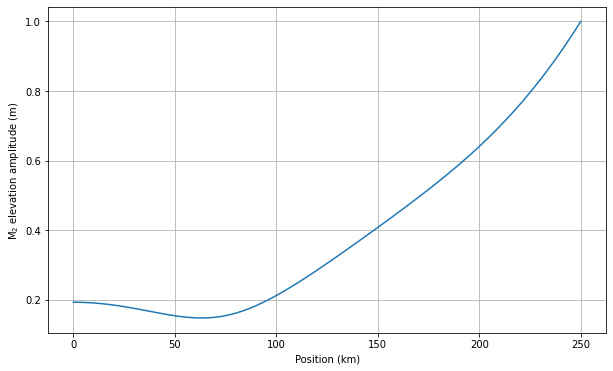

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(x / 1000, np.abs(eta))
plt.xlabel('Position (km)')
plt.ylabel('M$_2$ elevation amplitude (m)')
plt.show()

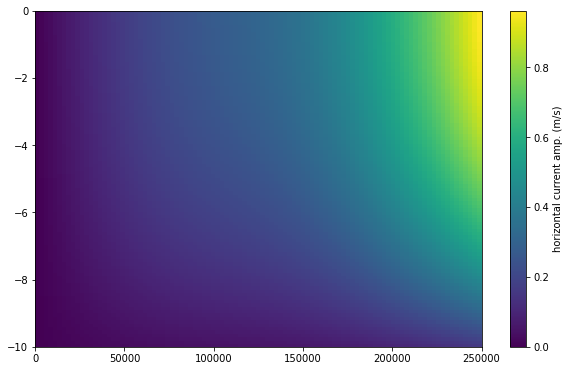

In [28]:
u = -1j * g / omega * (1 - beta * np.cosh(gamma * Z)) * np.exp(-.5 / lc * X) * (d0 * soln[0] * np.exp(d0 * X) - d0 * soln[1] * np.exp(-d0 * X)) 
plt.figure(figsize=(10, 6.18))
contour_u = plt.pcolor(X, Z, np.abs(u))
cbar = plt.colorbar(contour_u)
cbar.set_label('horizontal current amp. (m/s)')

# plt.figure(figsize=(10, 6.18))
# contour_u = plt.pcolor(X, Z, np.angle(u))
# cbar = plt.colorbar(contour_u)
# cbar.set_label('horizontal current phase (rad)')

## First order residual flows


In [35]:
r = Av / H / sf     # dimensionless slip parameter
fz = g * H**2 / Av * (.5 * ((Z/H)**2 - 1) - r)  # residual current vertical profile
coef = Av / g / H**3 / (1/3 + r)

### Stokes return flow

In [50]:
pressure_gradient_Stokes = coef * .5 * (np.real(eta.conjugate() * u[-1, :]))
u_Stokes = fz * pressure_gradient_Stokes
eta_Stokes = integrate.cumtrapz(pressure_gradient_Stokes[::-1], x[::-1], initial=0)[::-1]

In [45]:
# plt.plot(x, eta_Stokes)

In [52]:
# plt.pcolor(X,Z,u_Stokes)

## Velocity-depth asymmetry (vda, or no stress, or depth-deendent friction)

In [59]:
uzz_at_0 = 1j * g * beta * gamma**2 * np.cosh(0) * detadx[-1,0]
Fvda = .5 * np.real(eta.conjugate() * uzz_at_0)
pressure_gradient_vda = -coef * (.5 + r) * H**2 * Fvda
eta_vda = integrate.cumtrapz(pressure_gradient_vda[::-1], x[::-1], initial=0)[::-1]
u_vda = fz * pressure_gradient_vda

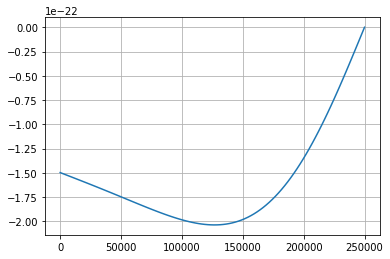

In [60]:
plt.plot(x, eta_vda)